# TD RL (PPO) Rotation + Same/Different Decision (Chiral Shapes)

This notebook uses the same **chiral shapes dataset** used in `exhaustive_search.ipynb` and other notebooks. We train a PPO agent to apply **rotation deltas** using `kornia.geometry.transform.rotate` to minimize MSE between a base shape and a target shape.

After rotation, we decide if the target is the **same shape** (just rotated) or a **different shape** (mirrored then rotated), by thresholding the **best alignment error** achieved during the rollout.


In [72]:
%cd /Users/masha/Documents/visual-reasoning

import math
import random
from dataclasses import dataclass

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import kornia.geometry.transform as K
import matplotlib.pyplot as plt
from sklearn import metrics

# Device + reproducibility
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


/Users/masha/Documents/visual-reasoning


## Dataset: Chiral Shapes (same as exhaustive_search / pipeline)


In [73]:
CHIRAL_SHAPES = {
    'L': [(0,-1),(0,0),(0,1),(1,1)],
    'Z': [(0,0),(-1,0),(0,1),(1,1)],
    'S': [(0,0),(1,0),(0,1),(-1,1)],
}

def draw_shape_np(name, size=64):
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block = size // 8
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + dx * block - block // 2
        y = center + dy * block - block // 2
        cv2.rectangle(img, (x, y), (x + block, y + block), 255, -1)
    return img

def norm_tensor(x):
    return (torch.tensor(x).float().unsqueeze(0) / 255.0 - 0.5) / 0.5

@torch.no_grad()
def sample_pair(size=64, force_same=None):
    key = random.choice(list(CHIRAL_SHAPES.keys()))
    base_np = draw_shape_np(key, size)

    angle = random.randint(0, 359)
    M = cv2.getRotationMatrix2D((size // 2, size // 2), angle, 1.0)

    if force_same is None:
        is_same = (random.random() > 0.5)
    else:
        is_same = bool(force_same)

    if is_same:
        target_np = cv2.warpAffine(base_np, M, (size, size))
        label = 1.0
    else:
        target_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (size, size))
        label = 0.0

    base = norm_tensor(base_np).unsqueeze(0).to(DEVICE)
    target = norm_tensor(target_np).unsqueeze(0).to(DEVICE)

    # Signed angle in [-180, 180]
    angle_signed = angle if angle <= 180 else angle - 360

    return base, target, label, angle_signed


## Rotation Environment

- State: 2-channel tensor `[current, target]`
- Action: rotation delta (degrees) applied with `K.rotate`
- Reward: `prev_error - new_error` (TD-style error reduction)


In [74]:
@dataclass
class RotationEnvConfig:
    max_steps: int = 24
    action_scale: float = 8.0  # max absolute delta per step (deg)
    done_threshold: float = 1e-4
    size: int = 64
    wrap_angle: bool = True
    same_only: bool = True  # train on same pairs only


class RotationEnv:
    def __init__(self, cfg: RotationEnvConfig):
        self.cfg = cfg
        self.device = DEVICE
        self.reset()

    def _mse(self, a, b):
        return F.mse_loss(a, b)

    def _obs(self):
        diff = self.target - self.current
        return torch.cat([self.current, self.target, diff], dim=1)

    def reset(self):
        self.steps = 0
        self.base, self.target, self.label, self.angle = sample_pair(self.cfg.size, force_same=self.cfg.same_only)
        self.current_angle = 0.0
        self.current = self.base.clone()
        with torch.no_grad():
            self.prev_error = self._mse(self.current, self.target).item()
        self.best_error = self.prev_error
        return self._obs().detach()

    def step(self, action_deg):
        action_deg = float(max(-self.cfg.action_scale, min(self.cfg.action_scale, action_deg)))
        self.steps += 1

        self.current_angle += action_deg
        if self.cfg.wrap_angle:
            if self.current_angle > 180.0:
                self.current_angle -= 360.0
            elif self.current_angle < -180.0:
                self.current_angle += 360.0

        with torch.no_grad():
            angle = torch.tensor([self.current_angle], device=self.device)
            self.current = K.rotate(self.base, angle)
            error = self._mse(self.current, self.target).item()

        # Reward: relative improvement with a small action penalty
        reward = (self.prev_error - error) / (self.prev_error + 1e-6) - 0.002 * (action_deg / self.cfg.action_scale) ** 2
        self.prev_error = error
        self.best_error = min(self.best_error, error)

        done = (self.steps >= self.cfg.max_steps) or (error <= self.cfg.done_threshold)
        info = {
            "error": error,
            "best_error": self.best_error,
            "label": self.label,
            "angle": self.angle,
            "current_angle": self.current_angle,
        }
        return self._obs().detach(), reward, done, info


## PPO Agent


In [75]:
class ActorCritic(nn.Module):
    def __init__(self, obs_shape):
        super().__init__()
        c, h, w = obs_shape
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        with torch.no_grad():
            n = self.encoder(torch.zeros(1, c, h, w)).view(1, -1).shape[1]
        self.policy = nn.Sequential(
            nn.Linear(n, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
        self.value = nn.Sequential(
            nn.Linear(n, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
        self.log_std = nn.Parameter(torch.tensor([-0.5]))

    def forward(self, obs):
        feat = self.encoder(obs).view(obs.size(0), -1)
        mean = self.policy(feat)
        value = self.value(feat)
        std = self.log_std.exp().expand_as(mean)
        return mean, std, value


def sample_action(model, obs, action_scale):
    mean, std, value = model(obs)
    dist = Normal(mean, std)
    raw_action = dist.rsample()
    action = torch.tanh(raw_action) * action_scale

    log_prob = dist.log_prob(raw_action)
    log_prob -= math.log(action_scale)
    log_prob -= torch.log(1 - torch.tanh(raw_action) ** 2 + 1e-6)
    log_prob = log_prob.sum(-1)

    return action, raw_action, log_prob, value

@torch.no_grad()
def deterministic_action(model, obs, action_scale):
    mean, std, value = model(obs)
    action = torch.tanh(mean) * action_scale
    return action


## PPO Training


In [76]:
# Hyperparameters
cfg = RotationEnvConfig(same_only=True)
steps_per_rollout = 256
ppo_epochs = 10
mini_batch_size = 64
clip_eps = 0.2
gamma = 0.99
lam = 0.95
value_coef = 0.5
entropy_coef = 0.01
lr = 3e-4
updates = 60

# Setup
env = RotationEnv(cfg)
obs_shape = env.reset().shape[1:]
model = ActorCritic(obs_shape).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

def compute_gae(rewards, values, dones, next_value):
    advantages = torch.zeros_like(rewards)
    gae = 0.0
    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * mask - values[t]
        gae = delta + gamma * lam * mask * gae
        advantages[t] = gae
        next_value = values[t]
    returns = advantages + values
    return advantages, returns

all_returns = []
obs = env.reset()

for update in range(updates):
    obs_buf = []
    raw_action_buf = []
    logp_buf = []
    reward_buf = []
    done_buf = []
    value_buf = []

    for step in range(steps_per_rollout):
        action, raw_action, logp, value = sample_action(model, obs, cfg.action_scale)
        next_obs, reward, done, info = env.step(action.item())

        obs_buf.append(obs)
        # Detach rollout tensors to avoid backprop through old graphs
        raw_action_buf.append(raw_action.detach())
        logp_buf.append(logp.detach())
        value_buf.append(value.squeeze(0).detach())
        reward_buf.append(torch.tensor(reward, dtype=torch.float32, device=DEVICE))
        done_buf.append(torch.tensor(float(done), device=DEVICE))

        obs = next_obs
        if done:
            all_returns.append(-info["best_error"])
            obs = env.reset()

    with torch.no_grad():
        _, _, next_value = model(obs)

    rewards = torch.stack(reward_buf)
    values = torch.stack(value_buf).squeeze(-1)
    dones = torch.stack(done_buf)
    advantages, returns = compute_gae(rewards, values, dones, next_value.item())
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    obs_batch = torch.cat(obs_buf, dim=0)
    raw_action_batch = torch.cat(raw_action_buf, dim=0)
    old_logp_batch = torch.cat(logp_buf, dim=0)
    returns_batch = returns.detach()
    adv_batch = advantages.detach()

    idxs = torch.randperm(steps_per_rollout)
    for _ in range(ppo_epochs):
        for start in range(0, steps_per_rollout, mini_batch_size):
            mb_idx = idxs[start:start + mini_batch_size]
            mb_obs = obs_batch[mb_idx]
            mb_raw_action = raw_action_batch[mb_idx]
            mb_old_logp = old_logp_batch[mb_idx]
            mb_returns = returns_batch[mb_idx]
            mb_adv = adv_batch[mb_idx]

            mean, std, value = model(mb_obs)
            dist = Normal(mean, std)

            logp = dist.log_prob(mb_raw_action)
            logp -= math.log(cfg.action_scale)
            logp -= torch.log(1 - torch.tanh(mb_raw_action) ** 2 + 1e-6)
            logp = logp.sum(-1)

            ratio = torch.exp(logp - mb_old_logp)
            surr1 = ratio * mb_adv
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * mb_adv
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(value.squeeze(-1), mb_returns)
            entropy = dist.entropy().mean()

            loss = policy_loss + value_coef * value_loss - entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if (update + 1) % 5 == 0:
        print(f"Update {update+1:02d} | recent returns: {all_returns[-5:]}")


Update 05 | recent returns: [-0.3747440576553345, -0.3790852427482605, -0.27107226848602295, -0.2869480848312378, -0.2575429081916809]
Update 10 | recent returns: [-0.24200111627578735, -0.3450947403907776, -0.3736097812652588, -0.14329686760902405, -0.07370372116565704]
Update 15 | recent returns: [-0.17884403467178345, -0.17922310531139374, -0.3395536541938782, -0.33396273851394653, -0.1733873188495636]
Update 20 | recent returns: [-0.26884785294532776, -0.2758767306804657, -0.2348535656929016, -0.2558528184890747, -0.25212934613227844]
Update 25 | recent returns: [-0.24462082982063293, -0.019666671752929688, -0.2524644732475281, -0.29357248544692993, -0.1505250781774521]
Update 30 | recent returns: [-0.1220717579126358, -0.3585307002067566, -0.17940965294837952, -0.21954643726348877, -0.1912325620651245]
Update 35 | recent returns: [-0.15385225415229797, -0.033890001475811005, -0.2070760726928711, -0.2538713216781616, -0.3268149197101593]
Update 40 | recent returns: [-0.252697169780

## Training Curve


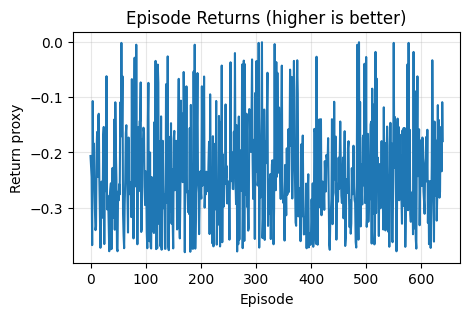

In [77]:
plt.figure(figsize=(5, 3))
plt.plot(all_returns)
plt.title("Episode Returns (higher is better)")
plt.xlabel("Episode")
plt.ylabel("Return proxy")
plt.grid(True, alpha=0.3)
plt.show()

## Evaluate: Alignment + Same/Different Decision

We compute the **best alignment MSE** achieved during a rollout. For classification, we use two rules:

1) **Threshold rule**: if best MSE is below a calibrated threshold, predict "same".
2) **Mirror-contrast rule**: run the policy on both the base and the mirrored base, then pick the one with lower best MSE.


Threshold (MSE): 0.222343
Accuracy (threshold): 45.00% | AUC: 0.4915
Accuracy (mirror-contrast): 52.33% | AUC: 0.5263


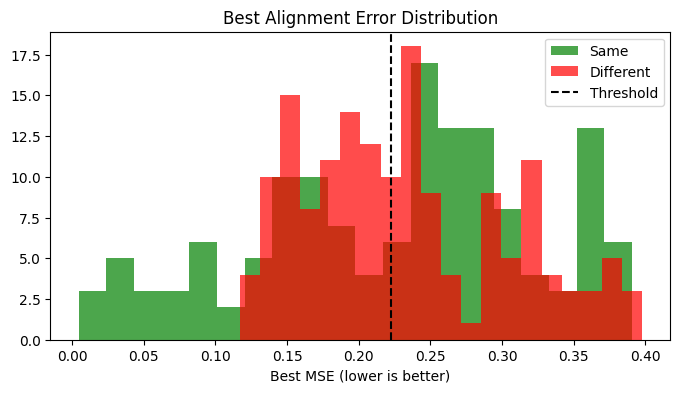

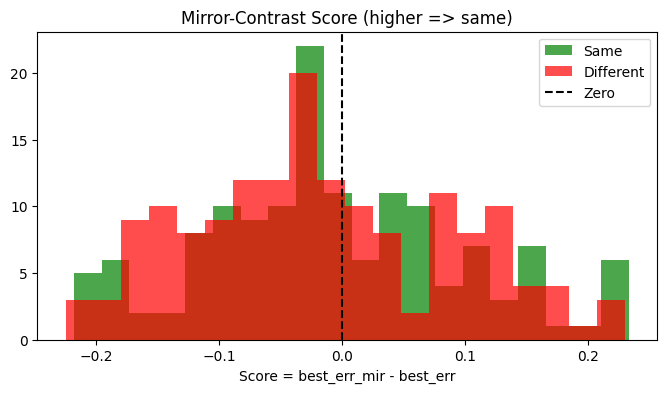

In [79]:
@torch.no_grad()
def mse_err(a, b):
    return torch.mean((a - b) ** 2).item()

@torch.no_grad()
def rollout_best_error_pair(model, base, target, cfg, deterministic=True):
    current_angle = 0.0
    current = base
    best_err = mse_err(current, target)

    obs = torch.cat([current, target, target - current], dim=1)
    for _ in range(cfg.max_steps):
        if deterministic:
            action = deterministic_action(model, obs, cfg.action_scale)
        else:
            action, _, _, _ = sample_action(model, obs, cfg.action_scale)

        action_deg = float(max(-cfg.action_scale, min(cfg.action_scale, action.item())))
        current_angle += action_deg
        if cfg.wrap_angle:
            if current_angle > 180.0:
                current_angle -= 360.0
            elif current_angle < -180.0:
                current_angle += 360.0

        current = K.rotate(base, torch.tensor([current_angle], device=base.device))
        err = mse_err(current, target)
        best_err = min(best_err, err)

        obs = torch.cat([current, target, target - current], dim=1)

    return best_err

@torch.no_grad()
def collect_metrics(model, n=300):
    errs = []
    errs_mir = []
    labels = []
    scores = []

    for _ in range(n):
        base, target, label, _ = sample_pair(force_same=None)
        err_base = rollout_best_error_pair(model, base, target, cfg, deterministic=True)

        base_mir = torch.flip(base, dims=[3])
        err_mir = rollout_best_error_pair(model, base_mir, target, cfg, deterministic=True)

        errs.append(err_base)
        errs_mir.append(err_mir)
        labels.append(label)
        scores.append(err_mir - err_base)  # higher => same

    return np.array(errs), np.array(errs_mir), np.array(labels), np.array(scores)

# Calibration set to pick a threshold
calib_errs, calib_errs_mir, calib_labels, calib_scores = collect_metrics(model, n=200)
mean_same = calib_errs[calib_labels == 1.0].mean()
mean_diff = calib_errs[calib_labels == 0.0].mean()
THRESHOLD = (mean_same + mean_diff) / 2.0

# Test set
errs, errs_mir, labels, scores = collect_metrics(model, n=300)

# Rule 1: threshold on best MSE
preds_thresh = (errs < THRESHOLD).astype(float)
acc_thresh = (preds_thresh == labels).mean()
auc_thresh = metrics.roc_auc_score(labels, -errs)

# Rule 2: mirror-contrast
preds_cmp = (errs < errs_mir).astype(float)
acc_cmp = (preds_cmp == labels).mean()
auc_cmp = metrics.roc_auc_score(labels, scores)

print(f"Threshold (MSE): {THRESHOLD:.6f}")
print(f"Accuracy (threshold): {acc_thresh*100:.2f}% | AUC: {auc_thresh:.4f}")
print(f"Accuracy (mirror-contrast): {acc_cmp*100:.2f}% | AUC: {auc_cmp:.4f}")

plt.figure(figsize=(8, 4))
plt.hist(errs[labels == 1.0], bins=20, alpha=0.7, color='green', label='Same')
plt.hist(errs[labels == 0.0], bins=20, alpha=0.7, color='red', label='Different')
plt.axvline(THRESHOLD, color='black', linestyle='--', label='Threshold')
plt.title("Best Alignment Error Distribution")
plt.xlabel("Best MSE (lower is better)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(scores[labels == 1.0], bins=20, alpha=0.7, color='green', label='Same')
plt.hist(scores[labels == 0.0], bins=20, alpha=0.7, color='red', label='Different')
plt.axvline(0.0, color='black', linestyle='--', label='Zero')
plt.title("Mirror-Contrast Score (higher => same)")
plt.xlabel("Score = best_err_mir - best_err")
plt.legend()
plt.show()

## Visualize a Few Decisions


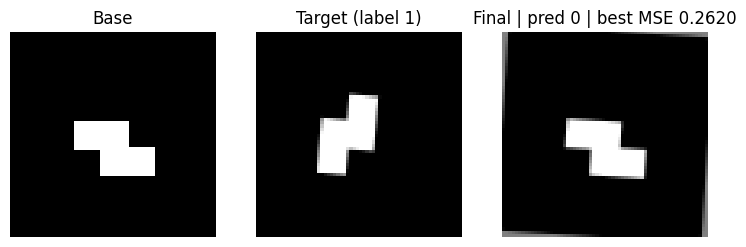

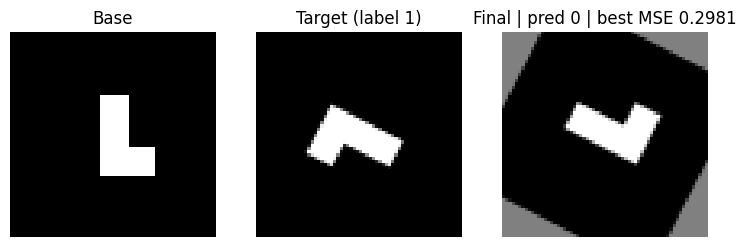

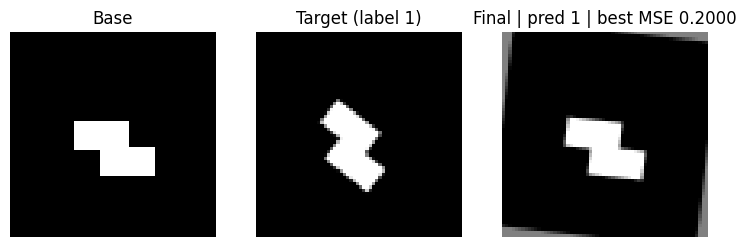

In [80]:
@torch.no_grad()
def run_and_visualize(n=3):
    for i in range(n):
        obs = env.reset()
        best_err = env.best_error
        for _ in range(env.cfg.max_steps):
            action = deterministic_action(model, obs, env.cfg.action_scale)
            obs, reward, done, info = env.step(action.item())
            best_err = min(best_err, info["error"])
            if done:
                break

        pred = 1.0 if best_err < THRESHOLD else 0.0

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(env.base[0,0].cpu(), cmap='gray')
        axes[0].set_title("Base")
        axes[0].axis('off')

        axes[1].imshow(env.target[0,0].cpu(), cmap='gray')
        axes[1].set_title(f"Target (label {int(env.label)})")
        axes[1].axis('off')

        axes[2].imshow(env.current[0,0].cpu(), cmap='gray')
        axes[2].set_title(f"Final | pred {int(pred)} | best MSE {best_err:.4f}")
        axes[2].axis('off')
        plt.show()

run_and_visualize(3)
